In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Data/train_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
test = pd.read_csv('Data/test_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
train, test

(        sample  ENC_POS_FLOATMAG_BH  dENC_X  ddENC_X  FLOATMAG_ACC_ADC_PORT_0  \
 2            2                  1.0     0.0     -3.0                    114.0   
 3            3                  2.0     1.0      1.0                    -76.0   
 4            4                  2.0     0.0     -1.0                     49.0   
 5            5                  0.0    -2.0     -2.0                    -10.0   
 6            6                 -1.0    -1.0      1.0                     41.0   
 ...        ...                  ...     ...      ...                      ...   
 210217    3873             100001.0     0.0     -2.0                    243.0   
 210218    3874             100000.0    -1.0     -1.0                     46.0   
 210219    3875             100004.0     4.0      5.0                     85.0   
 210220    3876             100000.0    -4.0     -8.0                    -26.0   
 210221    3877             100001.0     1.0      5.0                    -64.0   
 
         DAC_F

In [41]:
train

,sample,ENC_POS_FLOATMAG_BH,dENC_X,ddENC_X,FLOATMAG_ACC_ADC_PORT_0,DAC_FLOATMAG_BH,file,target
2,2,1.0,0.0,-3.0,114.0,-200.0,0,-76.0
3,3,2.0,1.0,1.0,-76.0,-191.0,0,49.0
4,4,2.0,0.0,-1.0,49.0,-171.0,0,-10.0
5,5,0.0,-2.0,-2.0,-10.0,-142.0,0,41.0
6,6,-1.0,-1.0,1.0,41.0,-127.0,0,-11.0
...,...,...,...,...,...,...,...,...
210217,3873,100001.0,0.0,-2.0,243.0,254.0,23,46.0
210218,3874,100000.0,-1.0,-1.0,46.0,259.0,23,85.0
210219,3875,100004.0,4.0,5.0,85.0,240.0,23,-26.0
210220,3876,100000.0,-4.0,-8.0,-26.0,270.0,23,-64.0


In [3]:

def build_training_set(data, sequence_length, prediction_timestep):

    #input data will just be matrix of values, timestep x (features + target)

    #output will be matrix: (data_trial x timestep x features) and (data_trial x target)

    #ok so we will have a trial for every data point, (because rolling window)
    #for timesteps that dont have he full sequence length, we will just pad with zeros
    #will remove nan values later

    #first lets pad the data with zeros (need sequence_length - 1 zeros)

    shape = data.shape

    num_features = shape[1] - 1 #subtract 1 for target

    zero_padding_features = np.zeros((sequence_length - 1, num_features))
    nan_padding_target = np.full((sequence_length - 1, 1), np.nan)
    to_pad_with = np.hstack((zero_padding_features, nan_padding_target))

    data = np.vstack((to_pad_with, data))


    #now lets build the training set

    X = []
    y = []

    for indx, i in enumerate(range(shape[0] - prediction_timestep)): #one trial for every data point except the last one (or however many we are predicting ahead)

        trial = data[i:i+sequence_length, :]

        #check for nan values
        if np.isnan(trial[:,:-1]).any() or np.isnan(trial[-1,-1]).any():
            continue

        X.append(trial[:,:-1])
        y.append([trial[-1,-1]])

    X = np.array(X)
    y = np.array(y)


    return X, y


    

In [71]:
sequence_length = 10
prediction_timestep = 1

train["target"] = train.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)

X, y = [], []

for file_num in train["file"].unique():

    data = train[train["file"] == file_num][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values

    X_temp, y_temp = build_training_set(data, sequence_length, prediction_timestep)

    X.extend(X_temp)
    y.extend(y_temp)

X = np.array(X)
y = np.array(y)


test["target"] = test.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)
X_test, y_test = [], []

for file_num in test["file"].unique():

    data = test[test["file"] == file_num][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values

    X_temp, y_temp = build_training_set(data, sequence_length, prediction_timestep)

    X_test.extend(X_temp)
    y_test.extend(y_temp)

X_test = np.array(X_test)
y_test = np.array(y_test)




In [20]:
X = np.array(X)
y = np.array(y)

In [21]:
X.shape, y.shape

((210150, 10, 4), (210150, 1))

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model = Sequential([
    Input(shape=(10, 4)),  # Input shape: 10 timesteps with 4 features each
    LSTM(50),  # LSTM layer with 50 units
    Dense(1)  # Output layer with 1 unit
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


2023-10-24 19:05:06.523292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 19:05:06.523440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 19:05:06.524954: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 19:05:06.654826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 19:05:09.803270: I tensorflow/compiler/

In [26]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_data = (X_test, y_test))


Epoch 1/10
6568/6568 [==============================] - 78s 12ms/step - loss: 4204649.5000 - mae: 827.3379 - val_loss: 4192027.2500 - val_mae: 825.1798
Epoch 2/10
6568/6568 [==============================] - 76s 12ms/step - loss: 4178551.7500 - mae: 821.8325 - val_loss: 4168741.7500 - val_mae: 820.3405
Epoch 3/10
6568/6568 [==============================] - 75s 11ms/step - loss: 4156010.2500 - mae: 818.0732 - val_loss: 4140720.5000 - val_mae: 815.6031
Epoch 4/10
6568/6568 [==============================] - 78s 12ms/step - loss: 4127510.5000 - mae: 812.9760 - val_loss: 4113463.5000 - val_mae: 810.1851
Epoch 5/10
6568/6568 [==============================] - 80s 12ms/step - loss: 4105978.0000 - mae: 808.9410 - val_loss: 4093822.7500 - val_mae: 804.8249
Epoch 6/10
6568/6568 [==============================] - 78s 12ms/step - loss: 4096497.0000 - mae: 807.3506 - val_loss: 4073321.0000 - val_mae: 801.6064
Epoch 7/10
6568/6568 [==============================] - 77s 12ms/step - loss: 4069250.50

In [70]:
mae = tf.keras.metrics.mean_absolute_error

In [ ]:
model

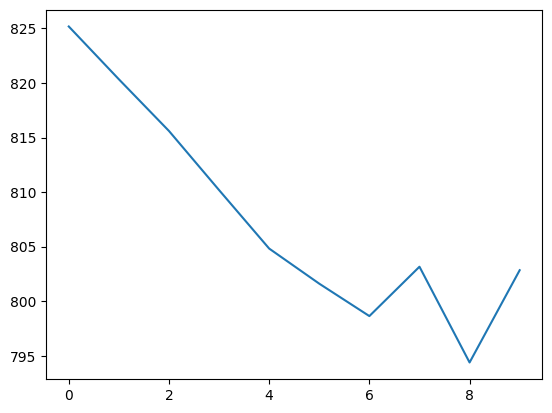

In [29]:

plt.plot(history.history["val_mae"])

In [34]:
test["target"] = test.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)
one_trial_test = test[test["file"] == 24][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values


In [40]:

X_test_one_trial, y_test_one_trial = build_training_set(one_trial_test, sequence_length, prediction_timestep)



In [42]:
X_test_one_trial.shape, y_test_one_trial.shape

((3627, 10, 4), (3627, 1))

114/114 [==============================] - 0s 4ms/step


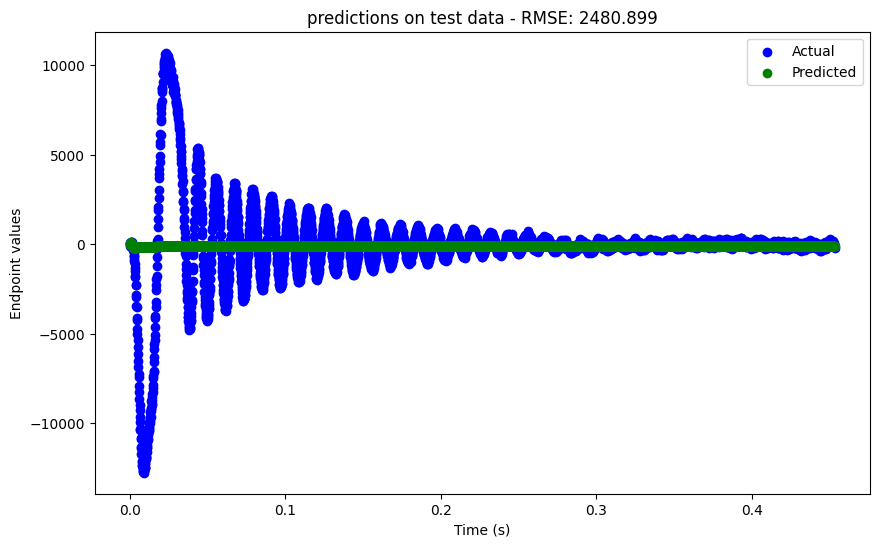

In [68]:
#now we need to use the model to predict on one file from the test data, to actually vizualize the predictions


times = np.array(range(len(X_test_one_trial))) / 8000

predictions_one_trial = model.predict(X_test_one_trial)
rmse_test = np.sqrt(mse(y_test_one_trial.flatten(), predictions_one_trial.flatten()))

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual')
plt.scatter(times, predictions_one_trial.flatten(), color='green', label='Predicted')


plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
plt.xlabel('Time (s)')
plt.ylabel('Endpoint values')
plt.legend()
plt.show()

In [66]:
predictions_one_trial[:100]

array([[-2.36485329e+01],
       [ 9.28385735e+00],
       [ 6.03774109e+01],
       [-5.75944901e+01],
       [-2.97165470e+01],
       [ 7.72376251e+01],
       [ 1.10912636e+02],
       [-5.13926430e+01],
       [-6.54404449e+01],
       [-2.25384541e+01],
       [-1.52613163e+01],
       [-7.74827003e-02],
       [-2.16082401e+01],
       [-1.15602768e+02],
       [-1.01880516e+02],
       [-1.64457733e+02],
       [-2.16675201e+02],
       [-2.27859024e+02],
       [-2.25357651e+02],
       [-2.25610809e+02],
       [-2.19130173e+02],
       [-2.18329697e+02],
       [-2.18423401e+02],
       [-2.18473892e+02],
       [-2.18491241e+02],
       [-2.18493683e+02],
       [-2.18504410e+02],
       [-2.18059845e+02],
       [-2.14903091e+02],
       [-2.11800430e+02],
       [-1.71641235e+02],
       [-1.66951950e+02],
       [-1.69205292e+02],
       [-1.69050888e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.6